In [30]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN
from collections import Counter

In [31]:
#Membaca dataset
df = pd.read_excel("PPG-BP dataset.xlsx", header=1)

In [32]:
# Lihat data awal
print(df.head(), "\n")

   Num.  subject_ID Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0     1           2   Female         45         152          63   
1     2           3   Female         50         157          50   
2     3           6   Female         47         150          47   
3     4           8     Male         45         172          65   
4     5           9   Female         46         155          65   

   Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                            161                              89   
1                            160                              93   
2                            101                              71   
3                            136                              93   
4                            123                              73   

   Heart Rate(b/m)  BMI(kg/m^2)          Hypertension Diabetes  \
0               97    27.268006  Stage 2 hypertension      NaN   
1               76    20.284799  Stage 2 hypertension   

In [33]:
#informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Num.                            219 non-null    int64  
 1   subject_ID                      219 non-null    int64  
 2   Sex(M/F)                        219 non-null    object 
 3   Age(year)                       219 non-null    int64  
 4   Height(cm)                      219 non-null    int64  
 5   Weight(kg)                      219 non-null    int64  
 6   Systolic Blood Pressure(mmHg)   219 non-null    int64  
 7   Diastolic Blood Pressure(mmHg)  219 non-null    int64  
 8   Heart Rate(b/m)                 219 non-null    int64  
 9   BMI(kg/m^2)                     219 non-null    float64
 10  Hypertension                    219 non-null    object 
 11  Diabetes                        38 non-null     object 
 12  cerebral infarction             20 n

In [34]:
# Cek jumlah missing values
print(df.isnull().sum())

Num.                                0
subject_ID                          0
Sex(M/F)                            0
Age(year)                           0
Height(cm)                          0
Weight(kg)                          0
Systolic Blood Pressure(mmHg)       0
Diastolic Blood Pressure(mmHg)      0
Heart Rate(b/m)                     0
BMI(kg/m^2)                         0
Hypertension                        0
Diabetes                          181
cerebral infarction               199
cerebrovascular disease           194
dtype: int64


In [35]:
# Hapus kolom tidak relevan
if 'Num.' in df.columns:
    df.drop('Num.', axis=1, inplace=True)
if 'subject_ID' in df.columns:
    df.drop('subject_ID', axis=1, inplace=True)

In [36]:
# Isi nilai kosong pada kolom kategorikal dengan 'Unknown'
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('Unknown')

# Isi nilai kosong pada kolom numerik dengan median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

In [37]:
# Hapus data duplikat
print("\nJumlah duplikasi:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


Jumlah duplikasi: 0


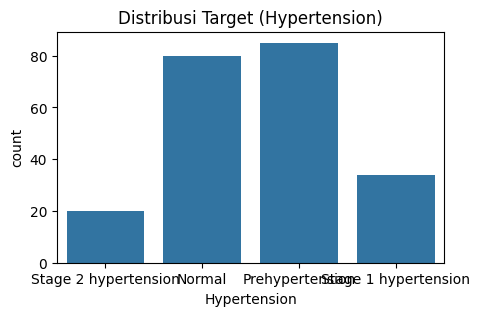

In [38]:
#Visualisasi distribusi target

plt.figure(figsize=(5, 3))
sns.countplot(x='Hypertension', data=df)
plt.title("Distribusi Target (Hypertension)")
plt.show()

In [39]:
#Encoding untuk kolom kategorikal
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

print("\n Data setelah encoding:")
print(df.head())


 Data setelah encoding:
   Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  Systolic Blood Pressure(mmHg)  \
0         0         45         152          63                            161   
1         0         50         157          50                            160   
2         0         47         150          47                            101   
3         1         45         172          65                            136   
4         0         46         155          65                            123   

   Diastolic Blood Pressure(mmHg)  Heart Rate(b/m)  BMI(kg/m^2)  Hypertension  \
0                              89               97    27.268006             3   
1                              93               76    20.284799             3   
2                              71               79    20.888889             0   
3                              93               87    21.971336             1   
4                              73               73    27.055151             1   

 

In [40]:
# Pisahkan fitur dan target
X = df.drop('Hypertension', axis=1)
y = df['Hypertension']

# Cek distribusi target sebelum SMOTE
print("\nDistribusi target sebelum ADASYN:")
print(y.value_counts())


Distribusi target sebelum ADASYN:
Hypertension
1    85
0    80
2    34
3    20
Name: count, dtype: int64


In [41]:
#Hybrid ADSYN SMOTE
try:
    adasyn_try = ADASYN(sampling_strategy='not majority', n_neighbors=3, random_state=42)
    X_res, y_res = adasyn_try.fit_resample(X, y)
    print("Berhasil ADASYN (one-shot):", Counter(y_res))
except Exception as e:
    print("One-shot ADASYN gagal:", e)
    # Opsi B: lakukan per-kelas
    X_res, y_res = X.copy(), y.copy()
    counts = Counter(y_res)
    max_count = max(counts.values())

    # Urutkan kelas berdasarkan jumlah (naik) — proses kelas paling kecil dulu
    classes_sorted = sorted(counts.items(), key=lambda x: x[1])
    for cls, cnt in classes_sorted:
        if cnt < max_count:
            # Target sementara: naikkan ke level yang lebih moderat dulu (mis. 1.2x atau sampai max_count)
            # Kamu bisa set target_to = max_count jika ingin samakan ke kelas mayoritas
            target_to = min(max_count, int(cnt + (max_count - cnt) * 0.9))
            sampling = {int(cls): int(target_to)}

            # Coba ADASYN untuk kelas ini
            try:
                ad = ADASYN(sampling_strategy=sampling, n_neighbors=3, random_state=42)
                X_res, y_res = ad.fit_resample(X_res, y_res)
                print(f"ADASYN sukses untuk kelas {cls} -> {Counter(y_res)[cls]} samples")
            except Exception as e_cls:
                print(f"ADASYN gagal untuk kelas {cls} dengan target {target_to}: {e_cls}")
                # Fallback: gunakan SMOTE untuk kelas ini
                try:
                    sm = SMOTE(sampling_strategy=sampling, k_neighbors=3, random_state=42)
                    X_res, y_res = sm.fit_resample(X_res, y_res)
                    print(f"SMOTE fallback sukses untuk kelas {cls} -> {Counter(y_res)[cls]} samples")
                except Exception as e_sm:
                    print(f"SMOTE juga gagal untuk kelas {cls}: {e_sm}")
                    # Jika masih gagal, kurangi target dan lanjutkan (agar pipeline tidak crash)
                    smaller_target = cnt + 10
                    if smaller_target > cnt:
                        try:
                            sm2 = SMOTE(sampling_strategy={int(cls): smaller_target}, k_neighbors=3, random_state=42)
                            X_res, y_res = sm2.fit_resample(X_res, y_res)
                            print(f"SMOTE fallback (smaller target) sukses untuk kelas {cls} -> {Counter(y_res)[cls]} samples")
                        except Exception as e_last:
                            print(f"Semua gagal untuk kelas {cls}, lanjutkan tanpa menambahnya: {e_last}")

    print("Hasil akhir distribusi:", Counter(y_res))


One-shot ADASYN gagal: No samples will be generated with the provided ratio settings.
ADASYN sukses untuk kelas 3 -> 76 samples
ADASYN sukses untuk kelas 2 -> 82 samples
ADASYN gagal untuk kelas 0 dengan target 84: No samples will be generated with the provided ratio settings.
SMOTE juga gagal untuk kelas 0: name 'SMOTE' is not defined
Semua gagal untuk kelas 0, lanjutkan tanpa menambahnya: name 'SMOTE' is not defined
Hasil akhir distribusi: Counter({1: 85, 2: 82, 0: 80, 3: 76})


In [42]:
#Split data menjadi train & test
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

# Normalisasi fitur numerik
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

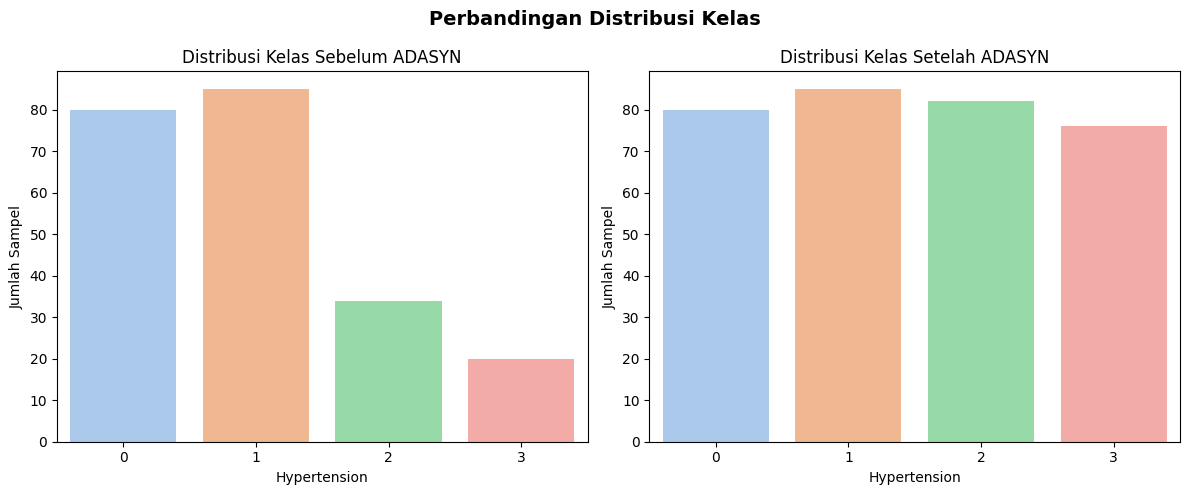

In [43]:
# Visualisasi Distribusi Kelas Sebelum & Sesudah ADASYN=
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Sebelum ADASYN
sns.countplot(x=y, hue=y, ax=axs[0], palette="pastel", legend=False)
axs[0].set_title("Distribusi Kelas Sebelum ADASYN")
axs[0].set_xlabel("Hypertension")
axs[0].set_ylabel("Jumlah Sampel")

# Sesudah ADASYN
sns.countplot(x=y_res, hue=y_res, ax=axs[1], palette="pastel", legend=False)
axs[1].set_title("Distribusi Kelas Setelah ADASYN")
axs[1].set_xlabel("Hypertension")
axs[1].set_ylabel("Jumlah Sampel")

plt.suptitle("Perbandingan Distribusi Kelas", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [44]:
# Model 1: Naive Bayes
print("\nModel: Naive Bayes")
nb = GaussianNB()

start = time.time()
nb.fit(X_train, y_train)
nb_time = time.time() - start

y_pred_nb = nb.predict(X_test)


Model: Naive Bayes


Akurasi: 0.8308
Waktu pelatihan: 0.0026 detik
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.88      0.71      0.79        21
           2       0.70      0.78      0.74        18
           3       0.86      0.92      0.89        13

    accuracy                           0.83        65
   macro avg       0.84      0.85      0.84        65
weighted avg       0.84      0.83      0.83        65



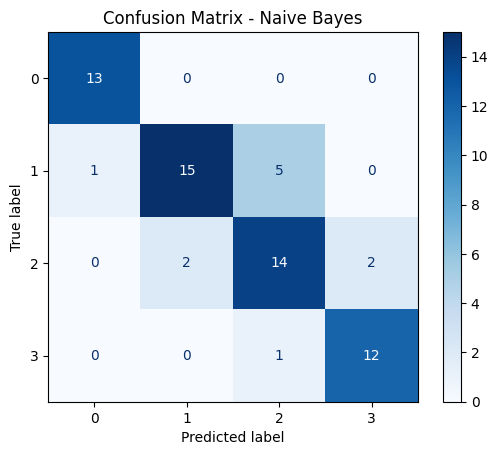

In [45]:
print(f"Akurasi: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Waktu pelatihan: {nb_time:.4f} detik")
print(classification_report(y_test, y_pred_nb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

In [46]:
# Model 2: SVM
print("\nModel: Support Vector Machine")
svm = SVC()
start = time.time()
svm.fit(X_train, y_train)
svm_time = time.time() - start
y_pred_svm = svm.predict(X_test)


Model: Support Vector Machine


Akurasi: 0.7692
Waktu pelatihan: 0.0090 detik
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.71      0.81      0.76        21
           2       0.82      0.78      0.80        18
           3       0.85      0.85      0.85        13

    accuracy                           0.77        65
   macro avg       0.78      0.76      0.77        65
weighted avg       0.77      0.77      0.77        65



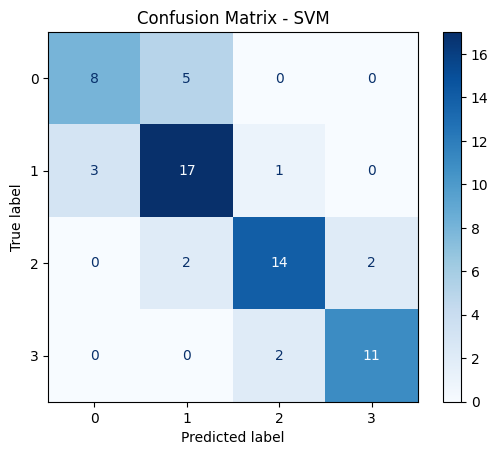

In [47]:
print(f"Akurasi: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Waktu pelatihan: {svm_time:.4f} detik")
print(classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()

In [48]:
# Model 3: Decision Tree
print("\nModel: Decision Tree")
model_dt = DecisionTreeClassifier(random_state=42)
start_time = time.time()
model_dt.fit(X_train, y_train)
dt_time = time.time() - start_time
y_pred_dt = model_dt.predict(X_test)


Model: Decision Tree


Akurasi: 1.0000
Waktu pelatihan: 0.0110 detik
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        13

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



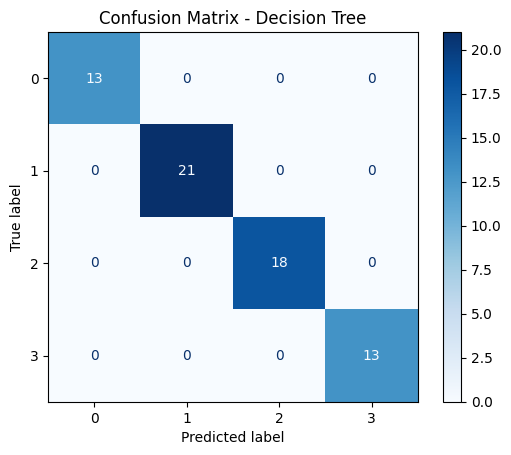

In [49]:
print(f"Akurasi: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Waktu pelatihan: {dt_time:.4f} detik")
print(classification_report(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

In [50]:
# Model 4: K-Nearest Neighbors
print("\nModel: K-Nearest Neighbors")
knn = KNeighborsClassifier()
start = time.time()
knn.fit(X_train, y_train)
knn_time = time.time() - start
y_pred_knn = knn.predict(X_test)


Model: K-Nearest Neighbors


Akurasi: 0.6769
Waktu pelatihan: 0.0077 detik
              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.63      0.57      0.60        21
           2       0.67      0.78      0.72        18
           3       0.79      0.85      0.81        13

    accuracy                           0.68        65
   macro avg       0.68      0.68      0.68        65
weighted avg       0.67      0.68      0.67        65



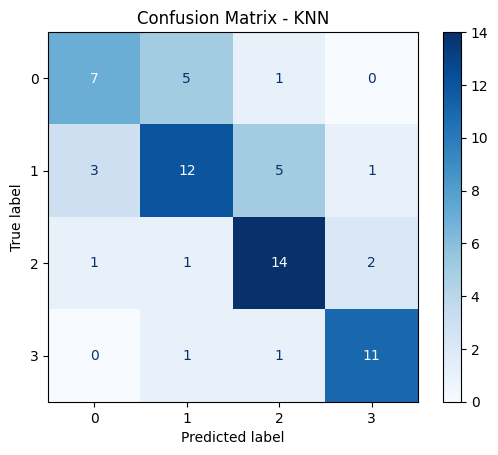

In [51]:
print(f"Akurasi: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Waktu pelatihan: {knn_time:.4f} detik")
print(classification_report(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.show()

In [52]:
# Model 5: Random Forest
print("\nModel: Random Forest")
rf = RandomForestClassifier(random_state=42)
start = time.time()
rf.fit(X_train, y_train)
rf_time = time.time() - start
y_pred_rf = rf.predict(X_test)


Model: Random Forest


Akurasi: 1.0000
Waktu pelatihan: 0.2989 detik
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        13

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



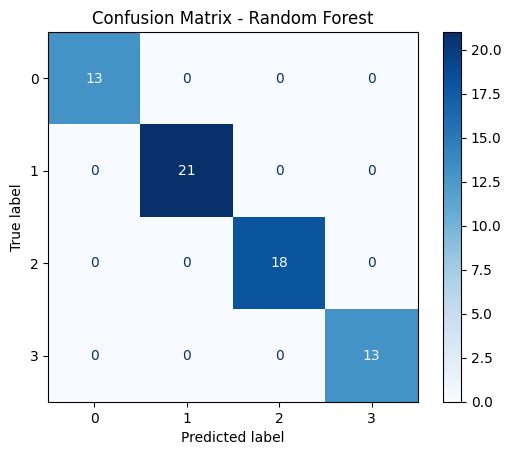

In [53]:
print(f"Akurasi: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Waktu pelatihan: {rf_time:.4f} detik")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

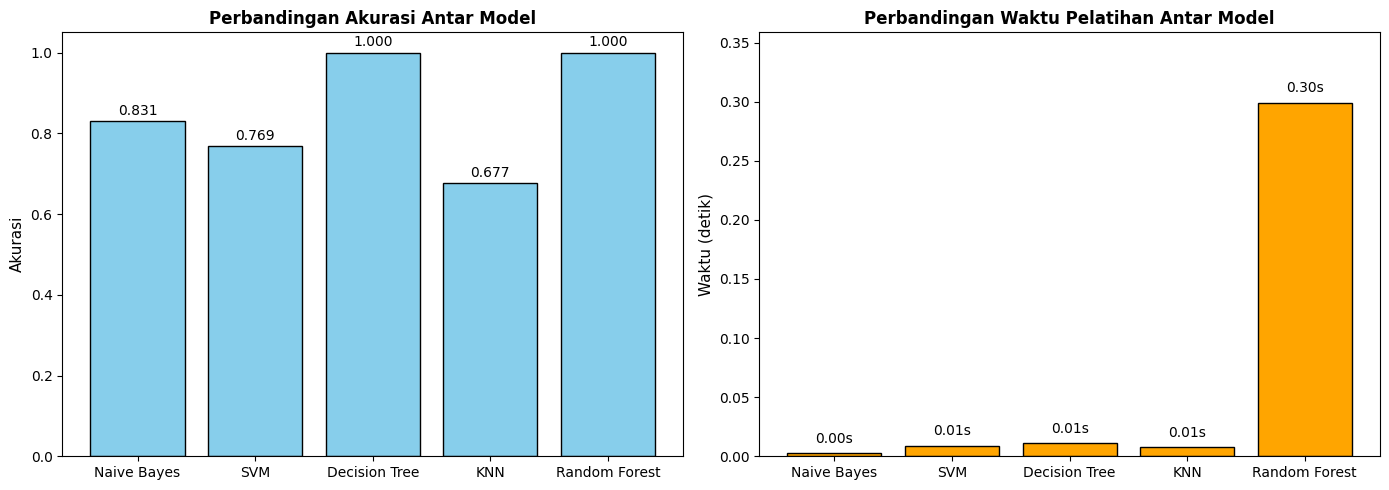

In [54]:
#Visualisasi Perbandingan Akurasi dan Waktu Pelatihan

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Daftar model dan hasilnya
model_names = ['Naive Bayes', 'SVM', 'Decision Tree', 'KNN', 'Random Forest']

accuracies = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_rf)
]

train_times = [nb_time, svm_time, dt_time, knn_time, rf_time]

#Membuat dua subplot (akurasi & waktu)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#Grafik Akurasi
ax[0].bar(model_names, accuracies, color='skyblue', edgecolor='black')
ax[0].set_title("Perbandingan Akurasi Antar Model", fontsize=12, fontweight='bold')
ax[0].set_ylabel("Akurasi", fontsize=11)
ax[0].set_ylim(0, 1)

max_acc = max(accuracies)
ax[0].set_ylim(0, min(1.05, max_acc + 0.05))

for i, v in enumerate(accuracies):
    ax[0].text(i, v + 0.015, f"{v:.3f}", ha='center', fontsize=10)

#Grafik Waktu Pelatihan
ax[1].bar(model_names, train_times, color='orange', edgecolor='black')
ax[1].set_title("Perbandingan Waktu Pelatihan Antar Model", fontsize=12, fontweight='bold')
ax[1].set_ylabel("Waktu (detik)", fontsize=11)

max_time = max(train_times)
ax[1].set_ylim(0, max_time * 1.2)

for i, v in enumerate(train_times):
    ax[1].text(i, v + (max_time * 0.03), f"{v:.2f}s", ha='center', fontsize=10)

plt.tight_layout()
plt.show()